shape: torch.Size([2, 128, 667]) 	 sample rate: 24000


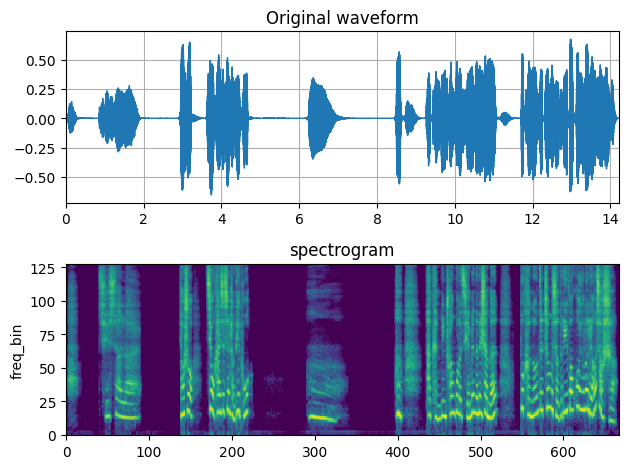

In [1]:
import librosa
import torch
import torchaudio
from matplotlib.patches import Rectangle
import torchcrepe
import matplotlib.pyplot as plt
from IPython.display import Audio

sample_rate = 24000
waveform, sr = torchaudio.load("/private/tmp/three_moon/side2_lc1_mar7th_224.wav", normalize=True)
if sr != sample_rate:
    waveform = torchaudio.functional.resample(waveform, sr, sample_rate)
    
n_fft = 2048
hop_length = 512
n_mels = 128
padding = 'center'
    
transform = torchaudio.transforms.MelSpectrogram(sample_rate,n_fft=n_fft,win_length=n_fft,hop_length=hop_length,n_mels=n_mels)
mel_specgram = transform(waveform)  # (channel, n_mels, time)
print(f"shape: {mel_specgram.shape} \t sample rate: {sample_rate}")

# 将Mel频谱图转换为numpy数组以便于绘图
mel_spectrogram_np = mel_specgram.numpy()

# 绘制Mel频谱图
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    
fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sample_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(mel_spectrogram_np[0], title="spectrogram", ax=axs[1])
fig.tight_layout()
Audio(waveform, rate=sample_rate)

In [2]:
audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram_np,sr=sample_rate,n_fft=n_fft,win_length=n_fft,hop_length=hop_length)
Audio(audio, rate=sample_rate)

In [3]:

from torchaudio import transforms
import torchaudio
from torchaudio.transforms import InverseMelScale, GriffinLim
from IPython.display import Audio

n_fft = 1024
n_stft = n_fft//2 + 1
n_mels = 100
hop_length = 256

waveform, sample_rate = torchaudio.load("output.wav", normalize=True)
# mel_spectrogram_transform = transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, n_mels=n_mels,hop_length=hop_length)
mel_spectrogram_transform = transforms.MelSpectrogram(n_mels=n_mels,sample_rate=sample_rate,n_fft=512,hop_length=256)
mel_spectrogram = mel_spectrogram_transform(waveform)
print(f"mel_spectrogram shape: {mel_spectrogram.shape}")


mel_spectrogram shape: torch.Size([1, 100, 708])


/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (100) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


audio shape: (341064,)
mel shape: (100, 1333)


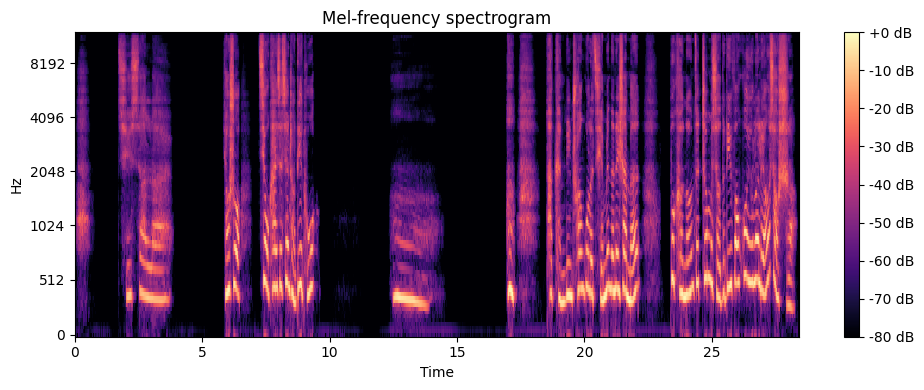

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

# 加载音频文件
audio_path = '/private/tmp/three_moon/side2_lc1_mar7th_224.wav'
sample_rate = 24000
y, sr = librosa.load(audio_path, sr=sample_rate, mono=True)  # sr=None 保持原始采样率
print(f"audio shape: {y.shape}")

# 计算 Mel 频谱图
n_fft = 1024
hop_length = 256
n_mels = 100
padding = 'center'

S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   win_length=None,
                                   center=True,
                                   pad_mode="reflect",
                                   power=2.0,
                                   n_mels=n_mels,
                                   norm="slaney",
                                   htk=True,
                                   )
print(f"mel shape: {S.shape}")

# 将 Mel 频谱图转换为分贝单位
S_dB = librosa.power_to_db(S, ref=np.max)

# 可视化 Mel 频谱图
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=sr/2)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

y_reconstructed = librosa.feature.inverse.mel_to_audio(
    S,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=None,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    htk=True,
    n_iter = 64,    # 迭代次数
)
Audio(y_reconstructed, rate=sr)

In [5]:
import torch

from vocos import Vocos

model = Vocos.from_hparams("/private/tmp/ChatTTS/config/vocos.yaml").eval()
model.load_state_dict(torch.load("/private/tmp/ChatTTS/asset/Vocos.pt"))

rebuild_audio = torch.from_numpy(S)[None]
print(rebuild_audio.shape)

audio = model.decode(rebuild_audio,sr=sample_rate)
Audio(audio.squeeze(0).squeeze(0).numpy(),rate=sample_rate)

/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 100, 1333])


In [6]:
y, sr = torchaudio.load(audio_path)
if y.size(0) > 1:  # mix to mono
    y = y.mean(dim=0, keepdim=True)
y = torchaudio.functional.resample(y, orig_freq=sr, new_freq=24000)
print(y.shape)
y_hat = model(y)
y_hat.shape
Audio(y_hat.squeeze().cpu().numpy(), rate=24000)

mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=24000,
            n_fft=1024,
            hop_length=256,
            n_mels=100,
            center=padding == "center",
            power=1,
        )

rebuild_audio = mel_spec(audio)
print(rebuild_audio.shape)
rebuild_audio = model.decode(rebuild_audio,sr=24000)
Audio(audio.squeeze(0).squeeze(0).numpy(),rate=24000)

torch.Size([1, 341064])
torch.Size([1, 100, 1333])
